# Crime data analysis

### I am trying to find which variables might have a higher correlation with crime data
The dataset I used for the analysis is 2011 Counties Data https://www.census.gov/library/publications/2011/compendia/usa-counties-2011.html?fbclid=IwAR2KsVfEDeUjvFvbtBSJTILVmYDRAjsJ6gnu-Q29YPMMXlZlfIZ6rdgOvpI#EAN

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing


## The dataset 
- The dataset have 96 csv files in total and is about 1.2 Gb.
- The dataset contains a lot of items belonging to 39 different catogeries including crime, housing, age and so on.
- In each category, there are columns of different data types. Most of the columns are absolute values of the county, but there are also median, percentage and ranking values.

### Combining the input data files with the metadata files to get a better interpretation

In [25]:
filelist = []
#files = os.listdir('../dataproject/crimedata/')
start_dir = '../dataproject/'
for root, dirs, files in os.walk(start_dir + 'crimedata/'):
    for filename in files:
        if (filename.endswith('.xls')): #and (not filename.startswith('CRM'))
            filelist.append(filename)

#dataabb = ['AFN','AGE','AGN','AGS','ANC','BNK', 'BPS','BZN','BZS','CLF','EAN','EAS','EDU','ELE','EMN','EMS','FED','GAN','GEE','GEN','HEA','HIS','HSD','HSG','INC','IPE','IRS','LFE','LND','LOG','MAN','MAS','NES','PEN','PIN','POP','PPQ','PST','PVY','RHI','RTN','RTS','SBO','SEX','SPR','VET','VST','WAT','WTN']

filedf = pd.DataFrame(filelist, columns = ['filename'])
filedf['abb'] = filedf['filename'].apply(lambda x: x[0:3])
filedf2 = pd.DataFrame(filedf.groupby(['abb'])['filename'].unique())
filedf2['Subj'] = filedf2.index
mastdf = pd.read_excel(start_dir + 'Mastgroups.xls')
filedf2 = pd.merge(filedf2, mastdf, how = 'left', on = 'Subj')

mastdatadf = pd.read_excel(start_dir + 'Mastdata.xls')
mastdatadf['Subj'] = mastdatadf['Item_Id'].apply(lambda x: x[0:3])
filedf2['numcolumns'] = list(mastdatadf.groupby('Subj')['Subj'].count())
filedf2['unit_indicator'] = list(mastdatadf.groupby('Subj')['Unit_Indicator'].unique())

In [26]:
filedf2.head()

,filename,Subj,Subject,numcolumns,unit_indicator
0,[AFN01.xls],AFN,Accommodation and Food Services - NAICS only,36,"[ABS, TH$]"
1,"[AGE01.xls, AGE03.xls, AGE02.xls, AGE04.xls]",AGE,Age,371,"[ABS, YRS, PCT]"
2,"[AGN01.xls, AGN02.xls]",AGN,Agriculture - NAICS,120,"[ABS, ACR, DOL, TH$, YRS]"
3,[AGS01.xls],AGS,Agriculture - SIC,24,"[ABS, ACR, DOL, TH$, YRS]"
4,"[ANC03.xls, ANC02.xls, ANC01.xls]",ANC,Ancestry,202,[ABS]


### Try to normalize data if the data is the total number by population

In [44]:
import re

def nor_indicator(listofwords):
    words = re.findall(r"[\w']+", listofwords.lower())
    if ('median' in words) | ('per' in words) | ('average' in words) | ('percentage' in words):
        return False
    else:
        return True
# print(nor_indicator('Private onfarm annual payroll - construction (NAICS 23) 1998'))
mastdatadf['normalize_indicator'] = mastdatadf['Item_Description'].apply(nor_indicator)

In [45]:
xls = pd.ExcelFile(start_dir + 'crimedata/PST01.xls')
for sheet in xls.sheet_names:
    if sheet == 'Sheet4':
        dfsheet = pd.read_excel(start_dir + 'crimedata/PST01.xls', sheetname = sheet)
        dfsheet = dfsheet.set_index('STCOU')
        dfsheet.fillna(0)
        for ix in dfsheet.index.values:
            if ix % 1000 == 0:
                dfsheet = dfsheet.drop([ix])
        for column in dfsheet.columns:
            if column == 'PST045208D':
                populationsheet = dfsheet[[column]]
populationsheet = populationsheet.replace(0, 1)

In [43]:
# if files start with the following string, they are not normalized by population
spegroups = ['AGN','AGS','LND','WAT','WTN','PST']
def inspegroups(string):
    flag = False
    for item in spegroups:
        if string.startswith(item):
            flag = True
            break
    return flag

def pcacomponents(variance, length):
    n = 0
    for i in range(length):
        if np.cumsum(variance)[i] > 0.9:
            n = i
            return n

## Data preprocessing

- The different csv files belonging to the same category are first combined to from a dataframe
- Drop some rows and columns and normalized colomns with absolute total numbers
- Normalize the dataframe along columns
- Do pca analysis of the new dataframe, keep several transformed columns which account for > 90% variance
- Combine these selected columns and store in a new file.

In [ ]:
Total_df = pd.DataFrame()
for i in range(len(filedf2)): # len(filedf2)
    df = pd.DataFrame()
    dflist = []
    for file in filedf2.iloc[i].filename:
        xls = pd.ExcelFile(start_dir + 'crimedata/'+file)
        for sheet in xls.sheet_names:
            dfsheet = pd.read_excel(start_dir + 'crimedata/' +file, sheetname = sheet)
            dfsheet = dfsheet.set_index('STCOU')
            dfsheet.fillna(0)
            for ix in dfsheet.index.values:
                if ix % 1000 == 0:
                    dfsheet = dfsheet.drop([ix])
            if (dfsheet.columns[0] == 'Area_name') or (dfsheet.columns[0] == 'Areaname'):
                dfsheet = dfsheet.drop([dfsheet.columns[0]], axis =1)
            for column in dfsheet.columns:
                if not column.endswith('D'):
                    dfsheet = dfsheet.drop(column,axis=1)
                elif list(dfsheet[column].value_counts())[0]/len(dfsheet) > 0.95:
                    dfsheet = dfsheet.drop([column], axis=1)
                elif len(mastdatadf[mastdatadf['Item_Id']==column]) == 0:
                    continue
                elif ((mastdatadf[mastdatadf['Item_Id']==column].Unit_Indicator.item() in ['ABS','ACR','ML$','TH$','DOL','THO','MIL']) \
                      and (not inspegroups(file))\
                      and mastdatadf[mastdatadf['Item_Id']==column].normalize_indicator.item()):
                # mastdatadf[mastdatadf['Item_Id']==column]['Unit_Indicator'] == 'ABS':
                    #print(dfsheet[column][0:5])
                    dfsheet[column] = np.multiply(np.array(dfsheet[column]), 1/np.array(populationsheet).reshape(len(populationsheet)))
            dflist.append(dfsheet)
    df = pd.concat(dflist, axis=1, ignore_index=False)
    x = df.values #returns a numpy array
    x_scaled = RobustScaler().fit_transform(x)
    df = pd.DataFrame(x_scaled)
    dfcorr = df.corr()
#     print(dfcorr)
    discards = []
    for k in range(len(dfcorr)):
        if not(k in discards):
            for kk in range(k+1, len(dfcorr)):
                if dfcorr[k][kk] >0.9:
                    discards.append(kk)
    discards = set(discards)
    df = df.drop(list(discards), axis=1)
    print('the data we are processing is ' + filedf2['Subject'][i])
    pca = PCA()
    pca.fit(df)
    # plt.plot(pca.explained_variance_ratio_, 'o')
    # plt.xlabel('component number')
    # plt.ylabel('explained variance')
    # plt.show()
    print('length of pca components is ', len(pca.components_))
    print('cumulative explained variance', np.cumsum(pca.explained_variance_ratio_)[0:2])
    n = pcacomponents(pca.explained_variance_ratio_, len(pca.components_))
    pca = PCA(n_components=n+1)
    pca = pca.fit(df)
    dfpca = pca.transform(df)
    print('%d components taken' %(n+1))
    # normalized_df = (df-df.min())/(df.max()-df.min())
    for j in range(n+1):
        col_name = filedf2.iloc[i]['Subj'] + '_' +str(j)
        Total_df[col_name] = dfpca[:,j]
Total_df['STCOU'] = list(populationsheet.index.values)
Total_df.set_index('STCOU',inplace=True)
print(Total_df.head())
Total_df.to_pickle('./data111.pkl') 

In [2]:
Total_df = pd.read_pickle('./data111original.pkl')

### The colinearity between selected features after preprocessing

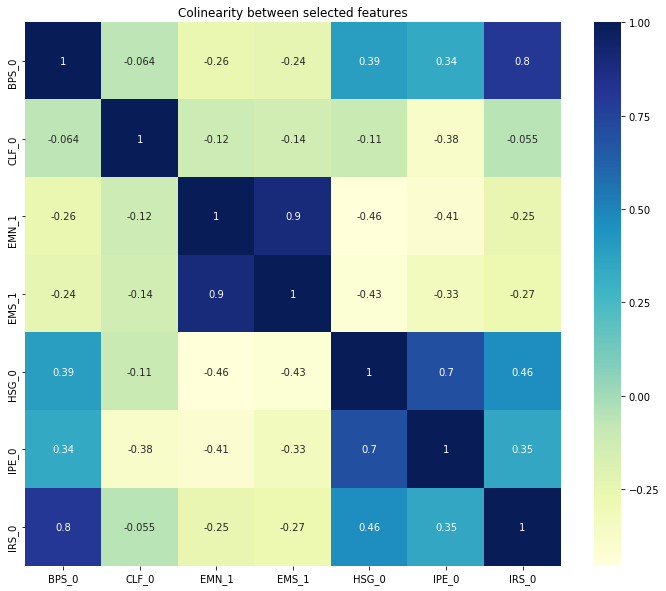

In [8]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
# datanew = pd.concat([metrics[columnstouse],crime_coeff],axis = 1 )
corrmat = Total_df.corr()
top_corr_features = corrmat.index[(abs(corrmat["IPE_0"]))>0.31]
datanew = Total_df[top_corr_features]
# for i in range(len(top_feats)):
#     top_feats[i] = top_feats[i].split('-')[0].split('(')[0]
f, ax = plt.subplots(figsize=(12, 10))
ax.xaxis.label.set_fontsize(20)
ax.set_title('Colinearity between selected features')
sns.heatmap(datanew.corr(), vmax=1, cmap="YlGnBu",annot=True, yticklabels=datanew.columns, xticklabels=datanew.columns);

## The preprocess of crime data

In [100]:
targetlist = []
#files = os.listdir("../Downloads/crimedata")
start_dir = '../Downloads/dataproject/'
for root, dirs, files in os.walk('./crimedata/'): #start_dir + 
    for filename in files:
        if filename.endswith('.xls') & filename.startswith('CRM'):
            targetlist.append(filename)

In [112]:
crime_df = pd.DataFrame()

crimelist = []
for file in targetlist:
    xls = pd.ExcelFile('./crimedata/'+file)
    for sheet in xls.sheet_names:
        dfsheet = pd.read_excel('./crimedata/' +file, sheetname = sheet)
        dfsheet = dfsheet.set_index('STCOU')
        dfsheet.fillna(0)
        for ix in dfsheet.index.values:
            if ix % 1000 == 0:
                dfsheet = dfsheet.drop([ix])
        if (dfsheet.columns[0] == 'Area_name') or (dfsheet.columns[0] == 'Areaname'):
            dfsheet = dfsheet.drop([dfsheet.columns[0]], axis =1)
        for column in dfsheet.columns:
            if not column.endswith('D'):
                dfsheet = dfsheet.drop(column,axis=1)
        crimelist.append(dfsheet)
crime_df = pd.concat(crimelist, axis=1, ignore_index=False)
crime_df.to_pickle('./crime_coefficient.pkl') 